In [7]:
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt
from keras.utils import timeseries_dataset_from_array
from keras import Input, Model
from keras.layers import Dense, Conv1D, MaxPooling1D, GlobalAveragePooling1D
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

In [8]:
print("Gpu disponível: ", tf.config.list_physical_devices('GPU'))

Gpu disponível:  []


In [9]:
import os

current_dir = os.getcwd()
path_file = os.path.join(current_dir, "datasets/jena_climate_2009_2016.csv")
df = pd.read_csv(path_file, header=0)

df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420451 entries, 0 to 420450
Data columns (total 15 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Date Time        420451 non-null  object 
 1   p (mbar)         420451 non-null  float64
 2   T (degC)         420451 non-null  float64
 3   Tpot (K)         420451 non-null  float64
 4   Tdew (degC)      420451 non-null  float64
 5   rh (%)           420451 non-null  float64
 6   VPmax (mbar)     420451 non-null  float64
 7   VPact (mbar)     420451 non-null  float64
 8   VPdef (mbar)     420451 non-null  float64
 9   sh (g/kg)        420451 non-null  float64
 10  H2OC (mmol/mol)  420451 non-null  float64
 11  rho (g/m**3)     420451 non-null  float64
 12  wv (m/s)         420451 non-null  float64
 13  max. wv (m/s)    420451 non-null  float64
 14  wd (deg)         420451 non-null  float64
dtypes: float64(14), object(1)
memory usage: 48.1+ MB


In [11]:
df = df.loc[:, df.columns != 'Date Time']

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420451 entries, 0 to 420450
Data columns (total 14 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   p (mbar)         420451 non-null  float64
 1   T (degC)         420451 non-null  float64
 2   Tpot (K)         420451 non-null  float64
 3   Tdew (degC)      420451 non-null  float64
 4   rh (%)           420451 non-null  float64
 5   VPmax (mbar)     420451 non-null  float64
 6   VPact (mbar)     420451 non-null  float64
 7   VPdef (mbar)     420451 non-null  float64
 8   sh (g/kg)        420451 non-null  float64
 9   H2OC (mmol/mol)  420451 non-null  float64
 10  rho (g/m**3)     420451 non-null  float64
 11  wv (m/s)         420451 non-null  float64
 12  max. wv (m/s)    420451 non-null  float64
 13  wd (deg)         420451 non-null  float64
dtypes: float64(14)
memory usage: 44.9 MB


In [13]:
X = df.loc[:, df.columns != 'T (degC)']
y = df.loc[:, 'T (degC)']

In [14]:
X.shape, y.shape

((420451, 13), (420451,))

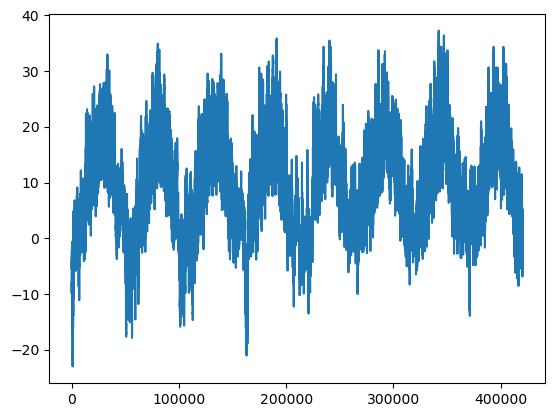

In [15]:
plt.plot(range(len(y)), y)

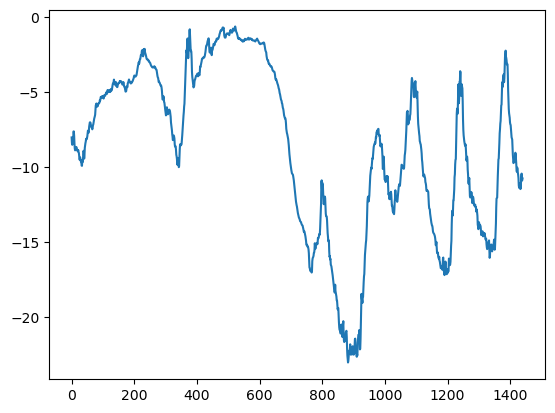

In [16]:
plt.plot(range(1440), y[:1440])

In [17]:
num_train_samples = int(0.5 * len(X))
num_val_samples = int(0.25 * len(X))
num_test_samples = len(X) - num_train_samples - num_val_samples

print('num_train_samples:', num_train_samples)
print('num_val_samples:', num_val_samples)
print('num_test_samples:', num_test_samples)

num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


In [18]:
mean = X[:num_train_samples].mean(axis=0)
X -= mean
std = X[:num_train_samples].std(axis=0)
X /= std

In [19]:
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_dataset = timeseries_dataset_from_array(
    X[:-delay],
    targets = y[delay:],
    sampling_rate = sampling_rate,
    sequence_length = sequence_length, 
    shuffle = True,
    batch_size = batch_size,
    start_index = 0,
    end_index = num_train_samples
)

val_dataset = timeseries_dataset_from_array(
    X[:-delay],
    targets = y[delay:],
    sampling_rate = sampling_rate,
    sequence_length = sequence_length,
    shuffle = True,
    batch_size = batch_size,
    start_index = num_train_samples,
    end_index = num_train_samples + num_val_samples
)

test_dataset = timeseries_dataset_from_array(
    X[:-delay],
    targets = y[delay:],
    sampling_rate = sampling_rate,
    sequence_length = sequence_length,
    shuffle = True,
    batch_size = batch_size,
    start_index = num_train_samples + num_val_samples
)

2025-01-23 13:47:51.425360: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 21863400 exceeds 10% of free system memory.


In [20]:
samples, targets = next(iter(train_dataset))
samples.shape 

2025-01-23 13:47:51.745566: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 21863400 exceeds 10% of free system memory.


TensorShape([256, 120, 13])

In [21]:
targets.shape

TensorShape([256])

In [22]:
inputs = Input(shape = (sequence_length, X.shape[-1]))
x = Conv1D(8, 24, activation='relu')(inputs)
x = MaxPooling1D(2)(x)
x = Conv1D(8, 12, activation='relu')(x)
x = MaxPooling1D(2)(x)
x = Conv1D(8, 6, activation='relu')(x)
x = GlobalAveragePooling1D()(x)
outputs = Dense(1)(x)
model = Model(inputs = inputs, outputs = outputs)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 120, 13)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 97, 8)          │         2,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 48, 8)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 37, 8)          │           776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 18, 8)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 13, 8)          │           392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 8)              │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,681 (14.38 KB)

 Trainable params: 3,681 (14.38 KB)

 Non-trainable params: 0 (0.00 B)

In [23]:
callbacks = [
    ModelCheckpoint('jena_dense.keras', save_best_only = True)
]

model.compile(optimizer = 'rmsprop',
                        loss = 'mse',
                        metrics=['mae'])

In [24]:
with tf.device('/device:GPU:0'):
    history = model.fit(train_dataset,
                        epochs = 10,
                        validation_data = val_dataset,
                        callbacks = callbacks)

Epoch 1/10
  3/819 ━━━━━━━━━━━━━━━━━━━━ 55s 68ms/step - loss: 132.9528 - mae: 9.6249

2025-01-23 13:47:53.375907: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 24210432 exceeds 10% of free system memory.
2025-01-23 13:47:53.376013: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 24210432 exceeds 10% of free system memory.
2025-01-23 13:47:53.382128: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 28448160 exceeds 10% of free system memory.


819/819 ━━━━━━━━━━━━━━━━━━━━ 65s 79ms/step - loss: 30.1456 - mae: 4.2685 - val_loss: 18.7045 - val_mae: 3.4749
Epoch 2/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 63s 77ms/step - loss: 16.2433 - mae: 3.1976 - val_loss: 14.9176 - val_mae: 3.0663
Epoch 3/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 78s 95ms/step - loss: 14.3563 - mae: 3.0062 - val_loss: 18.6489 - val_mae: 3.3881
Epoch 4/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 67s 81ms/step - loss: 13.3948 - mae: 2.8989 - val_loss: 15.2145 - val_mae: 3.0598
Epoch 5/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 56s 68ms/step - loss: 12.7061 - mae: 2.8234 - val_loss: 15.2888 - val_mae: 3.0760
Epoch 6/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 57s 69ms/step - loss: 12.2055 - mae: 2.7680 - val_loss: 15.3756 - val_mae: 3.0870
Epoch 7/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 60s 73ms/step - loss: 11.7357 - mae: 2.7141 - val_loss: 16.7753 - val_mae: 3.2306
Epoch 8/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 70s 85ms/step - loss: 11.3854 - mae: 2.6724 - val_loss: 15.4436 - val_mae: 3.0841
Epoch 9/10
819/819 ━━━━━━━━━━━━━━━━

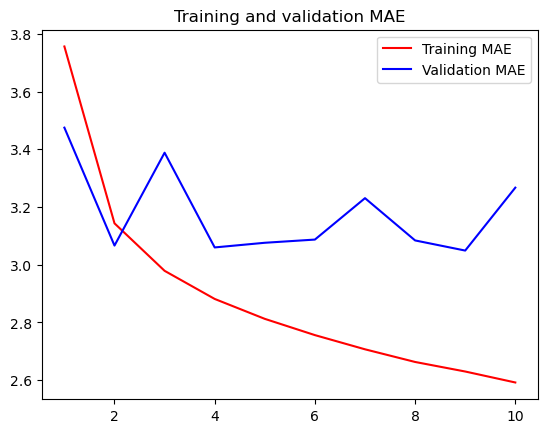

In [25]:
mae = history.history["mae"]
val_mae = history.history["val_mae"]
epochs = range(1, len(mae) + 1)
plt.figure()
plt.plot(epochs, mae, "r", label="Training MAE")
plt.plot(epochs, val_mae, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()